In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm

%matplotlib inline

In [2]:
def get_tuple(iterable):
    return tuple(sorted(iterable))

def diff(s, e):
    return get_tuple(set(s).difference([e]))

def subsets(s):
    res = []
    for i in range(len(s)+1):
        tmp = []
        for e in combinations(s, i):
            tmp += [list(e)]
        res += sorted(tmp)
        
    return res

def dict_max(d):
    tmp = None
    for k in d:
        if tmp is None:
            tmp = d[k]
        else:
            tmp = max(tmp, d[k])
            
    return tmp
            
def dict_argmax(d):
    tmp = None
    for k in d:
        if tmp is None:
            tmp = d[k]
            arg = k
        elif tmp < d[k]:
            tmp = d[k]
            arg = k
            
    return arg

In [3]:
class State:
    def __init__(self, i, j, cows, n, m, walls, ϵ):
        self.ϵ = ϵ
        self.i = i
        self.j = j
        self.cows = cows
        self.actions = []
        self.q = {}
        self.terminal = False
        
        if j < m-1 and (i, j, 'r') not in walls:
            self.actions.append('r')
        if j > 0 and (i, j, 'l') not in walls:
            self.actions.append('l')
        if i > 0 and (i, j, 'u') not in walls:
            self.actions.append('u')
        if i < n-1 and (i, j, 'd') not in walls:
            self.actions.append('d')
            
        self.actions_num = len(self.actions)
        
        for a in self.actions:
            self.q[a] = 0
        
    def __repr__(self):
        return "({i}, {j}, {c}), q: {q}, a: {a}".format(i=self.i, j=self.j, q=self.q, a=self.actions, c=len(self.cows))
        
    def make_terminal(self):
        self.terminal = True
        self.actions = ['.']
        self.actions_num = 1
        self.q = {'.': 0}
        
    def get_action(self):
        a = dict_argmax(self.q)
        if self.actions_num == 1:
            return a
        p = np.ones(self.actions_num) * self.ϵ / (self.actions_num - 1)
        items = list(self.q.items())
        for i, (k, v) in enumerate(items):
            if k == a:
                p[i] = 1 - ϵ
        return items[np.random.choice(np.arange(self.actions_num), p=p)][0]
        
    def next_state(self, action):        
        i, j = self.i, self.j
        
        if action == 'r': j += 1
        elif action == 'l': j -= 1
        elif action == 'u': i -= 1
        elif action == 'd': i += 1
        
        return i, j

In [4]:
def new_grid(cows, n, m, tx, ty, walls, ϵ):
    grid = {}
    comb = subsets(cows)
    for i in range(n):
        for j in range(m):
            for c in comb:
                if (i, j) in c:
                    continue
                grid[i, j, get_tuple(c)] = State(i, j, get_tuple(c), n, m, walls, ϵ)
                if i == tx and j == ty:
                    grid[i, j, get_tuple(c)].make_terminal()
                    
    return grid

In [5]:
def test_policy(grid, sx, sy, cows):
    s = grid[sx, sy, get_tuple(cows)]
    R = 0
    while not s.terminal:
        R -= 1
        i, j = s.next_state(dict_argmax(s.q))
        if (i, j) in cows:
            s = grid[i, j, diff(s.cows, (i, j))]
        else:
            s = grid[i, j, s.cows]
            
    R += 100 * (len(cows) - len(s.cows))
    
    return R

In [6]:
ϵ = 0.1
γ = 0.99
α = 1

In [7]:
N, M = 4, 2
walls = [(0,0,'r'),(0,1,'l'),(2,0,'r'),(2,1,'l'),(2,0,'d'),(3,0,'u')]
cows = set([(0,0),(0,1),(2,0),(2,1),(3,0),(3,1)])
sx, sy = 1, 0
tx, ty = 2, 0

In [10]:
grid = new_grid(cows, N, M, tx, ty, walls, ϵ)
np.random.seed(0)

reward = []
it = 20000

for k in tqdm(range(it)):
    
    s = grid[sx, sy, get_tuple(cows)]
    
    while not s.terminal:

        a = s.get_action()
        i, j = s.next_state(a)

        if (i, j) in cows:
            s_ = grid[i, j, diff(s.cows, (i, j))]
        else:
            s_ = grid[i, j, s.cows]

        R = -1 if not s_.terminal else 100 * (len(cows) - len(s_.cows)) if s != s_ else 0

        s.q[a] += α * (R + γ * dict_max(s_.q) - s.q[a])

        s = s_
    
    if k >= 100:
        reward += [test_policy(grid, sx, sy, cows)]

100%|███████████████████████████████████| 20000/20000 [00:44<00:00, 451.41it/s]


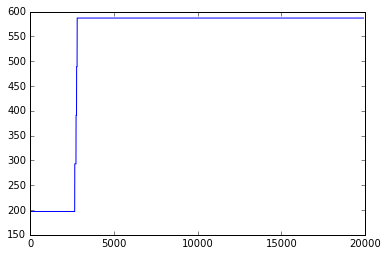

In [11]:
plt.plot(range(it - 100), reward)

In [12]:
abstract_grid = grid

In [13]:
def room(i, j):
    if j < 6:
        if i < 4: x, y = 0, 0
        elif i < 7: x, y = 1, 0
        else: x, y = 2, 0
    elif j < 12:
        if i > 8: x, y = 2, 1
        elif j < 9 and i > 3: x, y = 1, 1
        else: x, y = 0, 1
    elif i > 6: x, y = 3, 1
    else: x, y = 3, 0
    
    return x, y

In [14]:
def Φ(s, abstract_grid):
    x, y = room(s.i, s.j)
    m = 0
    
    for k, v in abstract_grid.items():
        if k[0] == x and k[1] == y:
            m = max(m, dict_max(v.q))
        
    return m

In [15]:
N, M = 13, 18

walls = [(i,5,'r') for i in range(N) if i != 5]; walls += [(i,6,'l') for i in range(N) if i != 5]
walls += [(i,12,'r') for i in range(N) if i != 11]; walls += [(i,13,'l') for i in range(N) if i != 11]
walls += [(i,8,'r') for i in range(4, 9) if i != 5]; walls += [(i,9,'l') for i in range(4, 9) if i != 5]
walls += [(3,j,'d') for j in range(9) if j != 4]; walls += [(4,j,'u') for j in range(9) if j != 4]
walls += [(6,j,'d') for j in range(6) if j != 1]; walls += [(7,j,'u') for j in range(6) if j != 1]
walls += [(8,j,'d') for j in range(6, 13) if j != 7]; walls += [(9,j,'u') for j in range(6, 13) if j != 7]

cows = set([(0,5),(2,7),(3,15),(8,3),(10,11),(12,17)])

sx, sy = 5, 4
tx, ty = 11, 1

In [16]:
grid = new_grid(cows, N, M, tx, ty, walls, ϵ)
np.random.seed(0)
it = 100

In [46]:
it = 1000

In [49]:
for k in tqdm(range(it)):
    
    s = grid[sx, sy, get_tuple(cows)]
    
    while not s.terminal:

        a = s.get_action()
        i, j = s.next_state(a)

        if (i, j) in cows:
            s_ = grid[i, j, diff(s.cows, (i, j))]
        else:
            s_ = grid[i, j, s.cows]

        R = -1 if not s_.terminal else 100 * (len(cows) - len(s_.cows)) if s != s_ else 0
                
        s.q[a] += α * (R + γ * Φ(s_, abstract_grid) - Φ(s, abstract_grid) + γ * dict_max(s_.q) - s.q[a])

        s = s_

100%|██████████████████████████████████████| 1000/1000 [01:16<00:00, 12.70it/s]


In [53]:
test_policy(grid, sx, sy, cows)

505